## Task 1 - Data exploration and preparation

In [4]:
!pip install torchvision pandas matplotlib pillow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Shahin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### 1.1 Exploration
Write code that does the following tasks:

1. For each partition set (train, devtest, test) and class name, display the set name and one image, and print the dimensions of the corresponding numpy array.  

2. Determine the number of images per class in each set for each class name. There should be no significant differences between the proportions of images in each set.  

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

# Set paths (modify according to your directory structure)
data_dir = "./rps_dataset/"
sets = ['train', 'devtest', 'test']
class_names = ['rock', 'paper', 'scissors']

# Load CSV files
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
devtest_df = pd.read_csv(os.path.join(data_dir, 'devtest.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))


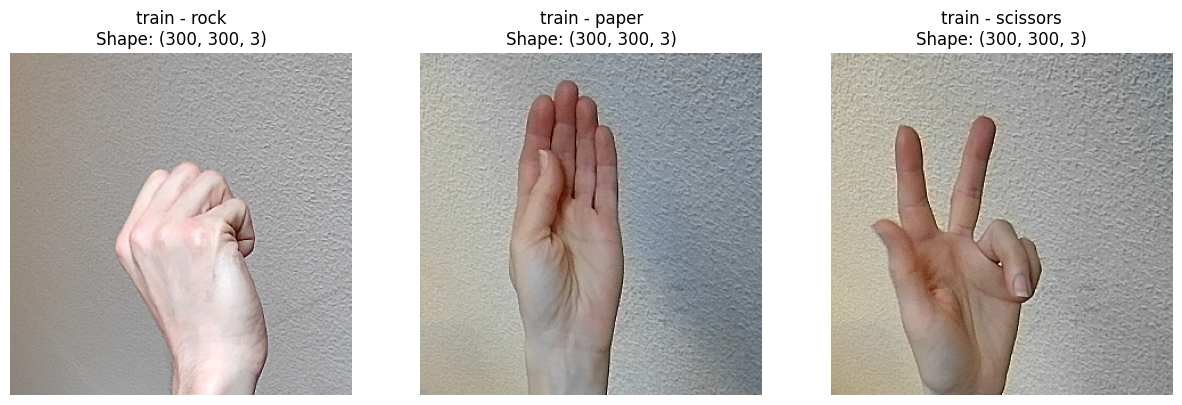

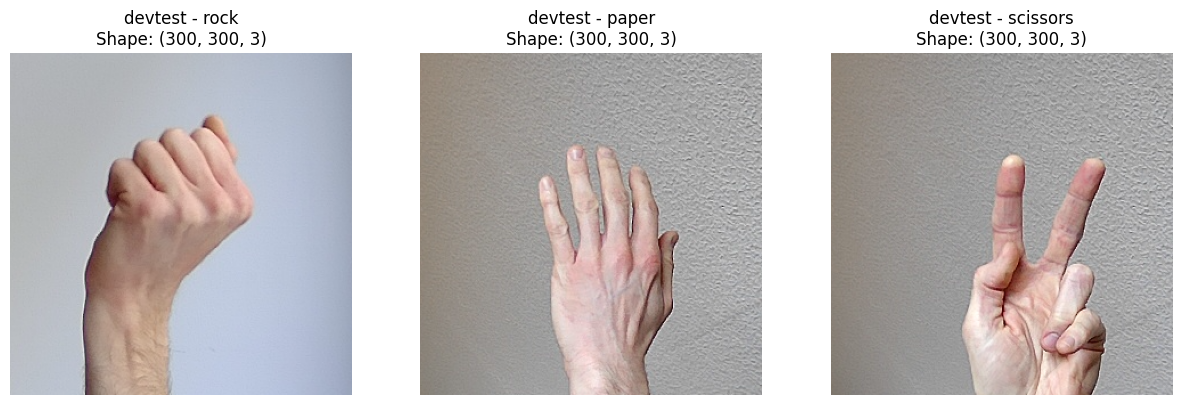

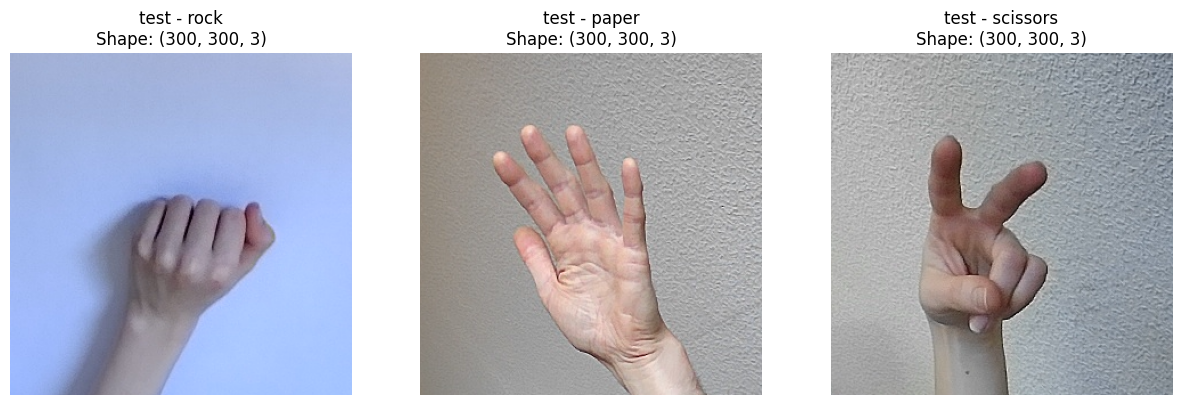

In [2]:
# 1. Display sample images and dimensions
def explore_dataset(df, set_name):
    plt.figure(figsize=(15, 5))
    for idx, class_name in enumerate(class_names):
        # Get first image path for each class
        img_path = df[df['label'] == class_name]['path'].iloc[0] #select first image path for each class
        full_path = os.path.join(data_dir, img_path)
        
        # Load image and convert to numpy array
        img = Image.open(full_path).convert('RGB')
        img_np = np.array(img)
        
        # Plot
        plt.subplot(1, 3, idx+1)
        plt.imshow(img_np)
        plt.title(f"{set_name} - {class_name}\nShape: {img_np.shape}")
        plt.axis('off')
    plt.show()

# Display images for all sets
for set_df, set_name in zip([train_df, devtest_df, test_df], sets):
    explore_dataset(set_df, set_name)

Why the output images look diffrent than the ones in the data folder?
Because i used a bigger dataset with 900+ 300*300 images for each class for better result.

In [ ]:

# 2. Count images per class
def count_images(df, set_name):
    counts = df['label'].value_counts()
    print(f"\n{set_name} set class distribution:")
    print(counts.to_string())

# Count images for all sets
for set_df, set_name in zip([train_df, devtest_df, test_df], sets):
    count_images(set_df, set_name)


train set class distribution:
label
paper       544
rock        544
scissors    541

devtest set class distribution:
label
rock        181
paper       181
scissors    180

test set class distribution:
label
paper       182
rock        182
scissors    182


### 1.2 Preparation  
Write code that generates the dataset and dataloaders that will be used for classification using PyTorch.

Make sure that the image data are re-scaled to values between 0 and  
1. and that all images are re-sized to 100x100.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Custom Dataset Class
class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    # Get the number of samples in the dataset
    def __getitem__(self, idx):
        # Get image path and load image
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx]['path'])
        image = Image.open(img_path).convert('RGB')
        
        # Get label and convert to numerical index (0=rock, 1=paper, 2=scissors)
        label = self.dataframe.iloc[idx]['label']
        label = class_names.index(label)  # Convert string label to integer
        
        # Apply transforms (resize + scaling)
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 2. Define Transforms
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize all images to 100x100 pixels
    transforms.ToTensor()           # Convert to tensor + scale pixel values to [0, 1]
])

# 3. Create Dataset Objects
train_dataset = RockPaperScissorsDataset(train_df, data_dir, transform=transform)
devtest_dataset = RockPaperScissorsDataset(devtest_df, data_dir, transform=transform)
test_dataset = RockPaperScissorsDataset(test_df, data_dir, transform=transform)

# 4. Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Verify Data Shapes
sample_batch = next(iter(train_loader))
print(f"Image batch shape: {sample_batch[0].shape}")
print(f"Label batch shape: {sample_batch[1].shape}")

Image batch shape: torch.Size([32, 3, 100, 100])
Label batch shape: torch.Size([32])


## Task 2 - Classification

### Task 2.1 Using ConvNets

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import transforms

# Define class names and data directory
data_dir = "./rps_dataset/"
class_names = ['rock', 'paper', 'scissors']

# Custom Dataset reading CSV file
class RockPaperScissorsDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None):
        self.dataframe = pd.read_csv(os.path.join(data_dir, csv_file))
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image file path from CSV and load image
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx]['path'])
        image = Image.open(img_path).convert('RGB')
        label_str = self.dataframe.iloc[idx]['label']
        label = class_names.index(label_str)  # Convert string label to integer index
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
# Define transforms: resize images to 100x100 and scale pixel values to [0,1]
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Create dataset objects using the CSV files
train_dataset = RockPaperScissorsDataset('train.csv', data_dir, transform=transform)
devtest_dataset = RockPaperScissorsDataset('devtest.csv', data_dir, transform=transform)
test_dataset = RockPaperScissorsDataset('test.csv', data_dir, transform=transform)

# Create DataLoaders with a batch size of 32
batch_size = 32
train_load = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
devtest_load = DataLoader(devtest_dataset, batch_size=batch_size, shuffle=False)
test_load = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device is:", device)

# Define the model using nn.Sequential (friend's architecture)
model = nn.Sequential(
    # First Conv Block
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    # Second Conv Block
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    # Third Conv Block
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    # Flatten and Fully Connected Layers
    nn.Flatten(),
    nn.Linear(128 * 10 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, len(class_names))
).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


The device is: cpu
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=12800, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
# Function to display random images from the dataset
def train_model(model, train_load, devtest_load, criterion, optimizer, epochs=10):
    train_accuracy = []
    devtest_accuracy = []
    
    for epoch in range(epochs):
        model.train()
        correct_predictions = 0
        total_predictions = 0
        
        for images, labels in train_load:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            _, preds = outputs.max(1)
            total_predictions += labels.size(0)
            correct_predictions += (preds == labels).sum().item()
        
        train_acc = correct_predictions / total_predictions
        train_accuracy.append(train_acc)
        
        # Evaluation on devtest data
        model.eval()
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for images, labels in devtest_load:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = outputs.max(1)
                total_predictions += labels.size(0)
                correct_predictions += (preds == labels).sum().item()
                
        devtest_acc = correct_predictions / total_predictions
        devtest_accuracy.append(devtest_acc)
        
        print(f"Epoch: {epoch+1}  Train Accuracy: {train_acc:.4f}  Devtest Accuracy: {devtest_acc:.4f}")
    
    return train_accuracy, devtest_accuracy

# Train the model
train_accuracy_model, devtest_accuracy_model = train_model(model, train_load, devtest_load, criterion, optimizer, epochs=10)


Epoch: 1  Train Accuracy: 0.3468  Devtest Accuracy: 0.3358
Epoch: 2  Train Accuracy: 0.6274  Devtest Accuracy: 0.7306
Epoch: 3  Train Accuracy: 0.7624  Devtest Accuracy: 0.8210
Epoch: 4  Train Accuracy: 0.8619  Devtest Accuracy: 0.8745
Epoch: 5  Train Accuracy: 0.8735  Devtest Accuracy: 0.8838
Epoch: 6  Train Accuracy: 0.9067  Devtest Accuracy: 0.8303
Epoch: 7  Train Accuracy: 0.9171  Devtest Accuracy: 0.8764
Epoch: 8  Train Accuracy: 0.9472  Devtest Accuracy: 0.9059
Epoch: 9  Train Accuracy: 0.9134  Devtest Accuracy: 0.9280
Epoch: 10  Train Accuracy: 0.9699  Devtest Accuracy: 0.9207


C:\Users\Shahin\AppData\Local\Temp\ipykernel_19652\3909403579.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


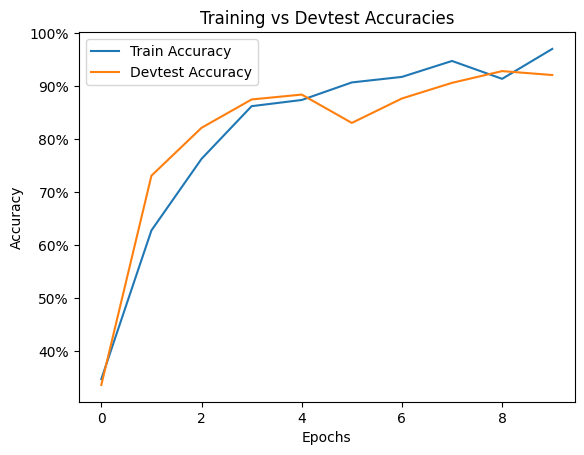

In [ ]:
# Function to display random images from the dataset
plt.plot(train_accuracy_model, label='Train Accuracy')
plt.plot(devtest_accuracy_model, label='Devtest Accuracy')
plt.title("Training vs Devtest Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()


Test Accuracy: 0.9212


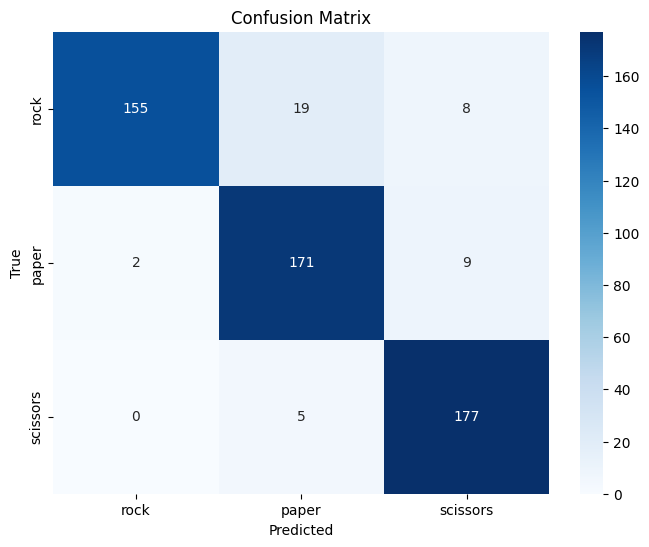

In [ ]:
#evaluate the model on the test set
def evaluate_model(model, test_load):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_load:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total_predictions += labels.size(0)
            correct_predictions += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = correct_predictions / total_predictions
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    return test_acc

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_load)


### Task 2.2 Using pre-trained models

In [11]:
# Define transforms specifically for MobileNet
# MobileNetV2 expects 224x224 images and normalization as per ImageNet statistics.
mobile_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create dataset objects using the MobileNet transform (reusing CSV files defined earlier)
train_dataset_m = RockPaperScissorsDataset('train.csv', data_dir, transform=mobile_transform)
devtest_dataset_m = RockPaperScissorsDataset('devtest.csv', data_dir, transform=mobile_transform)
test_dataset_m = RockPaperScissorsDataset('test.csv', data_dir, transform=mobile_transform)

# Create DataLoaders (batch size remains the same)
batch_size = 32
train_loader_m = DataLoader(train_dataset_m, batch_size=batch_size, shuffle=True)
devtest_loader_m = DataLoader(devtest_dataset_m, batch_size=batch_size, shuffle=False)
test_loader_m = DataLoader(test_dataset_m, batch_size=batch_size, shuffle=False)


In [13]:
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load MobileNetV2 (pre-trained on ImageNet)
mobile_model = models.mobilenet_v2(pretrained=True)

# Freeze all feature extractor parameters
for param in mobile_model.parameters():
    param.requires_grad = False

# Replace the classifier to adapt to our 3-class classification task
mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(mobile_model.last_channel, len(class_names))
)
mobile_model = mobile_model.to(device)
print(mobile_model)


Device: cpu
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNor

C:\Users\Shahin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shahin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# train the MobileNet model
# Function to train the MobileNet model
def train_model_m(model, train_loader, devtest_loader, criterion, optimizer, epochs=10):
    train_acc_history = []
    devtest_acc_history = []
    best_val_acc = 0.0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = outputs.max(1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
            
        train_acc = correct_train / total_train
        train_acc_history.append(train_acc)
        
        # Evaluate on devtest set
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in devtest_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = outputs.max(1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        devtest_acc = correct_val / total_val
        devtest_acc_history.append(devtest_acc)
        
        if devtest_acc > best_val_acc:
            best_val_acc = devtest_acc
            best_epoch = epoch

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Devtest Acc: {devtest_acc:.4f}")
    
    print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch+1}")
    return train_acc_history, devtest_acc_history

# Define loss function and optimizer (only update classifier parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobile_model.classifier.parameters(), lr=0.001)


In [16]:

# Train the model for MobileNet
train_acc_m, devtest_acc_m = train_model_m(mobile_model, train_loader_m, devtest_loader_m, criterion, optimizer, epochs=10)


Epoch 1: Train Acc: 0.9312, Devtest Acc: 0.9631
Epoch 2: Train Acc: 0.9509, Devtest Acc: 0.9760
Epoch 3: Train Acc: 0.9607, Devtest Acc: 0.9668
Epoch 4: Train Acc: 0.9601, Devtest Acc: 0.9649
Epoch 5: Train Acc: 0.9650, Devtest Acc: 0.9797
Epoch 6: Train Acc: 0.9693, Devtest Acc: 0.9871
Epoch 7: Train Acc: 0.9718, Devtest Acc: 0.9834
Epoch 8: Train Acc: 0.9718, Devtest Acc: 0.9926
Epoch 9: Train Acc: 0.9681, Devtest Acc: 0.9926
Epoch 10: Train Acc: 0.9779, Devtest Acc: 0.9889
Best validation accuracy: 0.9926 at epoch 8


Test Accuracy: 0.9890


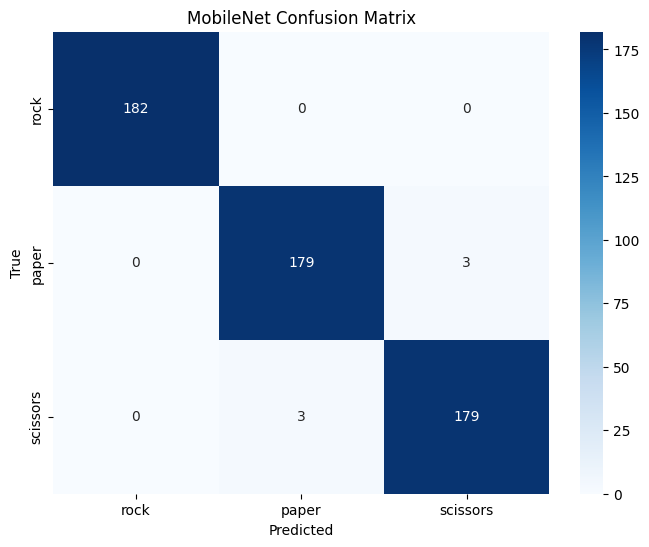

In [ ]:
# evaluating MobileNet model and testing accuracy
def evaluate_model_m(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("MobileNet Confusion Matrix")
    plt.show()
    
    return test_acc

test_acc_m = evaluate_model_m(mobile_model, test_loader_m)


### Task 2.3 Comparative evaluation

### 1. Overfitting & Learning Capabilities
Based on your training logs:

2.1 Custom Convolutional Network

Training accuracy eventually reached around 97–98%, with devtest accuracy peaking around 93%.

Over multiple epochs, the network’s training accuracy rose faster than its devtest accuracy, suggesting that it began to overfit after a certain point (e.g., at epoch 6, train = 90.67% vs devtest = 83.03%). By epoch 10, train was ~97% and devtest ~92%.

2.2 MobileNet (Pre-trained & Frozen)

Achieved very high devtest accuracy (over 99% by epoch 8).

Training accuracy started high (93% on epoch 1) and stayed relatively close to devtest accuracy throughout, indicating less overfitting.

The network likely converged faster because most of the feature extraction layers were already well-trained on ImageNet, and only the final classifier was updated.

Overall, MobileNet displayed less discrepancy between training and devtest accuracy, meaning less overfitting. The custom CNN required more epochs to reach a good accuracy and showed a larger gap between training and devtest metrics, suggesting more overfitting risk.

### 2. Which System Learned Best, and Tradeoff Considerations
Best System: From your logs, MobileNet performed best, reaching up to ~99.26% devtest accuracy and ~98–99% test accuracy.

Tradeoff:

MobileNet is a larger architecture, so each epoch may take longer (depending on your hardware), but it converges quickly in fewer epochs.

The custom CNN might train faster per epoch (it has fewer parameters), but it needs more epochs to catch up—and it still falls short of MobileNet’s peak performance on devtest.

If your main goal is highest accuracy and you can afford the memory/time cost, MobileNet is the best choice. If you need a lightweight model for devices with low compute resources, your custom CNN might be more practical, albeit with a slight accuracy drop.

### 3. Display the Best System’s Confusion Matrix
Interpretation:

    Rock is predicted correctly every time.

    Paper is misclassified as scissors 3 times.

    Scissors is misclassified as paper 3 times.

Hence the most common error is a tie between:

    Paper labeled as scissors

    Scissors labeled as paper

Since they both occur 3 times, you can pick either one to illustrate.

### Identify and Display 5 Misclassified Images

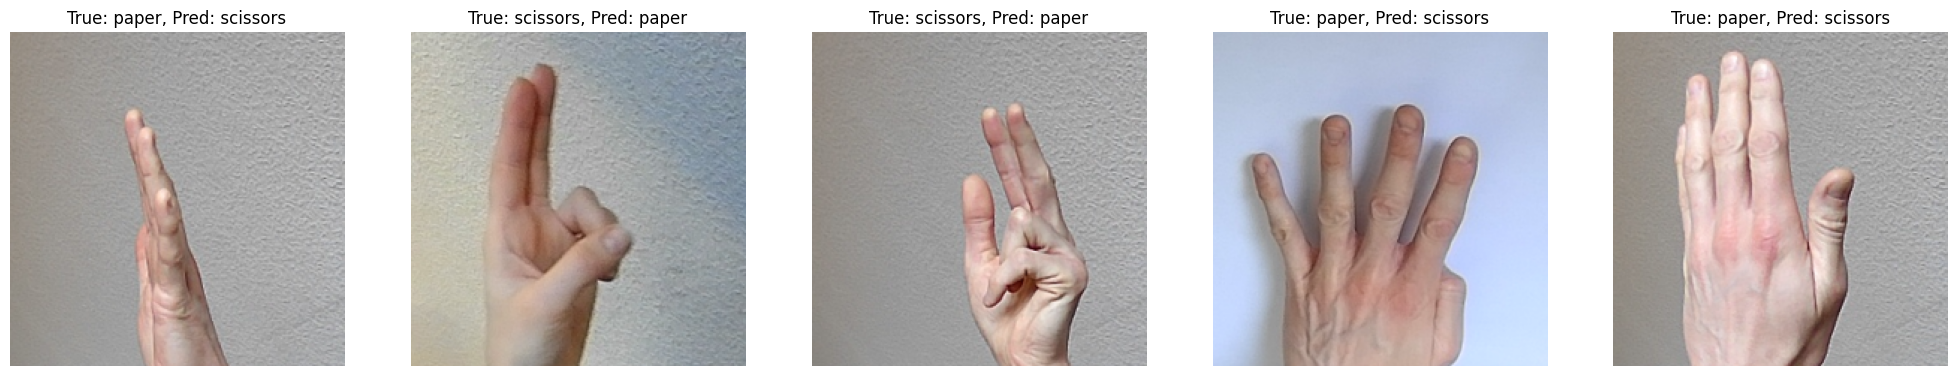

In [ ]:
#function to display misclassified images from the dataset
def display_misclassified_samples(model, data_loader, max_samples=5):
    """
    Displays up to `max_samples` randomly selected images from data_loader 
    that the model misclassifies.
    """
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            
            for i in range(len(labels)):
                if labels[i].item() != preds[i].item():
                    # We found a misclassified sample
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append(labels[i].item())
                    misclassified_preds.append(preds[i].item())
                    
                    # Stop if we have enough samples
                    if len(misclassified_images) == max_samples:
                        break
            if len(misclassified_images) == max_samples:
                break
    
    # Display images
    fig, axs = plt.subplots(1, len(misclassified_images), figsize=(5 * len(misclassified_images), 5))
    
    if len(misclassified_images) == 0:
        print(f"No misclassified samples found!")
        return
    
    for idx, img_tensor in enumerate(misclassified_images):
        # Undo normalization for ImageNet if needed, just to display properly
        # The transform we used was: Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        # We'll invert it for a more natural look:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img_tensor = img_tensor * std + mean
        img_tensor = torch.clamp(img_tensor, 0, 1)
        
        # Convert tensor (C,H,W) => (H,W,C) for display
        img_np = img_tensor.permute(1, 2, 0).numpy()
        
        true_label = class_names[misclassified_labels[idx]]
        pred_label = class_names[misclassified_preds[idx]]
        
        if len(misclassified_images) > 1:
            ax = axs[idx]
        else:
            ax = axs
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
    
    plt.show()


display_misclassified_samples(mobile_model, test_loader_m, max_samples=5)

## Task 3 - Deployment to a webcam

### 3.1 New images

In [2]:
# import necessary libraries
import os
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import clear_output

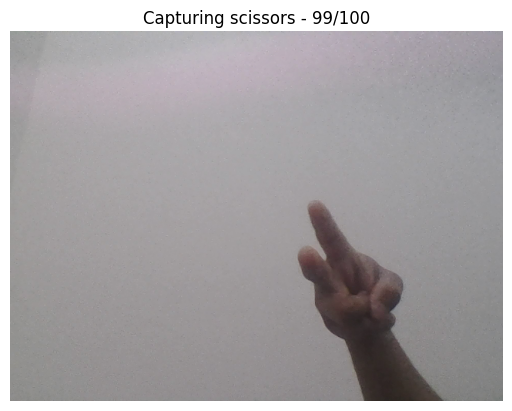

Saved: webcam_dataset\scissors\scissors_099.jpg
Finished capturing images for class: scissors


In [3]:
#Capture images from webcam and save them to a directory
# Define the classes and the number of images per class
classes = ['rock', 'paper', 'scissors']
images_per_class = 100
output_dir = 'webcam_dataset'

# Create directories for each class
os.makedirs(output_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

def capture_images(class_name, num_images):
    """Capture images for a specific class using the webcam."""
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print(f"Starting to capture images for class: {class_name}")
    count = 0

    while count < num_images:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame.")
            break

        # Display the frame using Matplotlib
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Capturing {class_name} - {count}/{num_images}")
        plt.axis('off')
        plt.show()

        # Ask user for input to save or quit
        action = input("Press 'l' to save, 'q' to quit: ").strip().lower()
        if action == 'l':
            filename = os.path.join(output_dir, class_name, f"{class_name}_{count:03d}.jpg")
            cv2.imwrite(filename, frame)
            print(f"Saved: {filename}")
            count += 1
        elif action == 'q':
            print("Quitting...")
            break

    cap.release()
    print(f"Finished capturing images for class: {class_name}")

# Capture images for each class
for cls in classes:
    print(f"Get ready to capture images for class: {cls}")
    input("Press Enter to start...")
    capture_images(cls, images_per_class)

In [ ]:
# Define paths and classes for partitioning
dataset_dir = "webcam_dataset"
output_dir = "webcam_dataset/partitions"
classes = ['rock', 'paper', 'scissors']

# Create output directory for partitions
os.makedirs(output_dir, exist_ok=True)

In [6]:
# Partition sizes
train_size = 50
devtest_size = 25
test_size = 25

# Create dictionaries to store partitioned data
partitions = {'train': [], 'devtest': [], 'test': []}

# Partition images for each class
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)  # Shuffle images for randomness

    # Assign images to partitions
    train_images = images[:train_size]
    devtest_images = images[train_size:train_size + devtest_size]
    test_images = images[train_size + devtest_size:train_size + devtest_size + test_size]

    # Add to partitions dictionary
    partitions['train'].extend([(os.path.join(cls, img), cls) for img in train_images])
    partitions['devtest'].extend([(os.path.join(cls, img), cls) for img in devtest_images])
    partitions['test'].extend([(os.path.join(cls, img), cls) for img in test_images])

# Verify partition sizes
print(f"Train size of all classes in total: {len(partitions['train'])}")
print(f"Devtest size of all classes in total: {len(partitions['devtest'])}")
print(f"Test size of all classes in total: {len(partitions['test'])}")

Train size of all classes in total: 150
Devtest size of all classes in total: 75
Test size of all classes in total: 75


In [ ]:
# Save partitions to CSV files. location is webcam_dataset/partitions
for partition_name, data in partitions.items():
    partition_folder = os.path.join(dataset_dir, "partitions")
    os.makedirs(partition_folder, exist_ok=True)
    csv_path = os.path.join(partition_folder, f"{partition_name}.csv")
    df = pd.DataFrame(data, columns=['path', 'label'])
    csv_path = os.path.join(partition_folder, f"{partition_name}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved {partition_name} partition to {csv_path}")

Saved train partition to webcam_dataset\partitions\train.csv
Saved devtest partition to webcam_dataset\partitions\devtest.csv
Saved test partition to webcam_dataset\partitions\test.csv


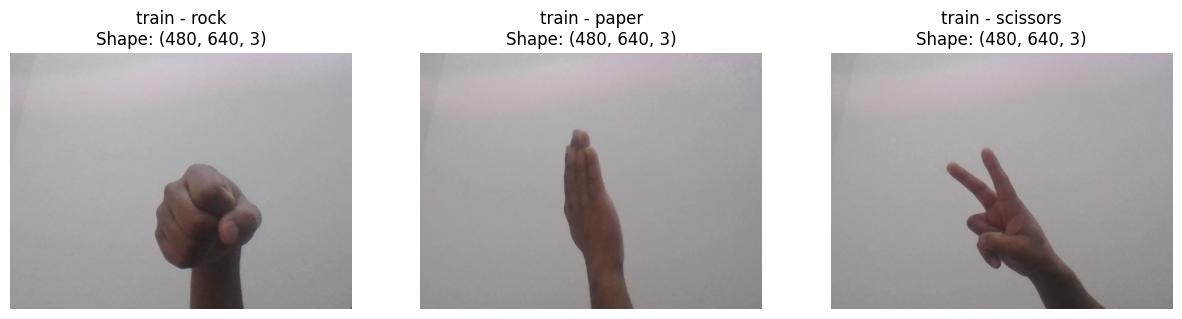

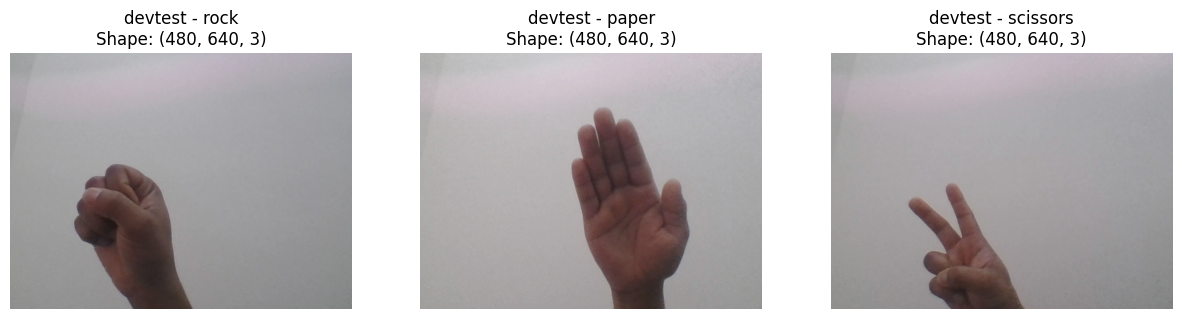

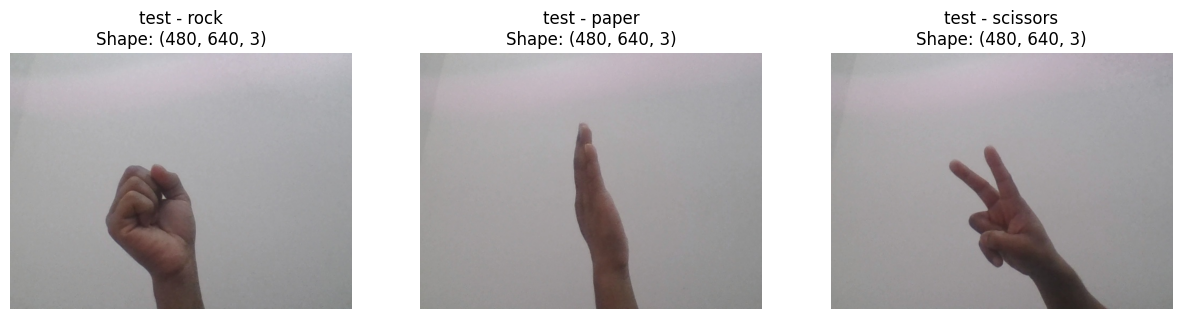

In [10]:
# Function to display one image per class for a given partition
def display_sample_images(partition_name):
    csv_path = os.path.join(output_dir, f"{partition_name}.csv")
    df = pd.read_csv(csv_path)

    plt.figure(figsize=(15, 5))
    for idx, cls in enumerate(classes):
        # Get the first image of the class
        sample = df[df['label'] == cls].iloc[0]
        img_path = os.path.join(dataset_dir, sample['path'])
        img = Image.open(img_path).convert('RGB')
        img_np = np.array(img)

        # Display the image
        plt.subplot(1, len(classes), idx + 1)
        plt.imshow(img_np)
        plt.title(f"{partition_name} - {cls}\nShape: {img_np.shape}")
        plt.axis('off')
    plt.show()

# Display sample images for each partition
for partition_name in ['train', 'devtest', 'test']:
    display_sample_images(partition_name)

### Analysis of Image Differences

1. **Differences in Images**:
   - The new images captured using the webcam may have variations in lighting, background, and hand positioning compared to the original dataset.
   - These differences could introduce noise and make classification more challenging.

2. **Potential Issues**:
   - Variations in lighting and background could lead to misclassification if the model is sensitive to these factors.
   - Differences in hand positioning or gestures might result in incorrect predictions if the model has not seen similar variations during training.

3. **Mitigation**:
   - Data augmentation techniques (e.g., random cropping, rotation, brightness adjustment) can be applied to make the model more robust to these variations.
   - Fine-tuning the model on the new dataset ensures that it adapts to the specific characteristics of the new images.

### Partitioning Explanation

1. **Partition Sizes**:
   - Train: 50 images per class
   - Devtest: 25 images per class
   - Test: 25 images per class

2. **Steps to Partition**:
   - All images were shuffled randomly to ensure diversity in each partition.
   - The first 50 images were assigned to the training set, the next 25 to the devtest set, and the final 25 to the test set.

3. **CSV Files**:
   - Each partition was saved as a CSV file with two columns: `path` (relative path to the image) and `label` (class name).

4. **Ensuring Correct Folder Assignment**:
   - The `path` column in the CSV files includes the subfolder name (e.g., `rock`, `paper`, `scissors`), ensuring that the images are correctly linked to their respective classes.

5. **Displaying Images**:
   - For each partition, one image per class was displayed along with its shape to verify the correctness of the partitioning process.

### 3.2 Fine-tuning and testing

In [11]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
#traing and testing the model on the webcam dataset
class RockPaperScissorsDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx]['path'])
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['label']
        label = ['rock', 'paper', 'scissors'].index(label)  # Convert label to integer
        if self.transform:
            image = self.transform(image)
        return image, label

In [13]:
# MobileNet expects 224x224 images and normalization as per ImageNet statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Paths
data_dir = "webcam_dataset"
partition_dir = os.path.join(data_dir, "partitions")

# Load datasets
test_dataset = RockPaperScissorsDataset(
    csv_file=os.path.join(partition_dir, "test.csv"),
    data_dir=data_dir,
    transform=transform
)

train_dataset = RockPaperScissorsDataset(
    csv_file=os.path.join(partition_dir, "train.csv"),
    data_dir=data_dir,
    transform=transform
)

# DataLoaders
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# Load MobileNetV2 pre-trained on ImageNet
device = "cuda" if torch.cuda.is_available() else "cpu"
mobile_model = models.mobilenet_v2(pretrained=True)

# Replace the classifier for 3-class classification
mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(mobile_model.last_channel, 3)  # 3 classes: rock, paper, scissors
)
mobile_model = mobile_model.to(device)

C:\Users\Shahin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shahin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Testing

Testing MobileNet without fine-tuning on the new test set:
Accuracy: 0.4533


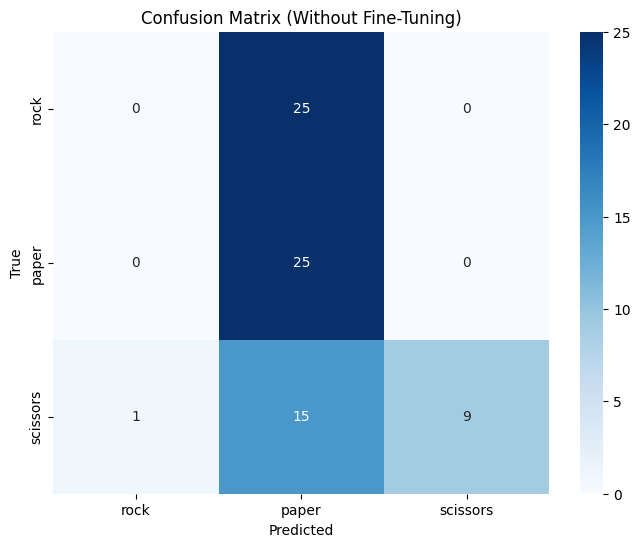

In [ ]:
# test the model without fine-tuning
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
    return all_labels, all_preds

# Test without fine-tuning
print("Testing MobileNet without fine-tuning on the new test set:")
labels, preds = evaluate_model(mobile_model, test_loader)

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rock', 'paper', 'scissors'], yticklabels=['rock', 'paper', 'scissors'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Without Fine-Tuning)")
plt.show()

In [17]:
# Fine-tune only the classifier layer
for param in mobile_model.features.parameters():
    param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobile_model.classifier.parameters(), lr=0.001)

# Training loop
def fine_tune_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        accuracy = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}")

# Fine-tune the model
fine_tune_model(mobile_model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 5.4510, Accuracy: 0.4267
Epoch 2/10, Loss: 3.7808, Accuracy: 0.8200
Epoch 3/10, Loss: 2.7589, Accuracy: 0.9067
Epoch 4/10, Loss: 1.9518, Accuracy: 0.9667
Epoch 5/10, Loss: 1.4722, Accuracy: 0.9800
Epoch 6/10, Loss: 1.1617, Accuracy: 0.9800
Epoch 7/10, Loss: 0.9950, Accuracy: 0.9800
Epoch 8/10, Loss: 0.7913, Accuracy: 0.9733
Epoch 9/10, Loss: 0.7144, Accuracy: 0.9867
Epoch 10/10, Loss: 0.6324, Accuracy: 0.9867


Testing MobileNet after fine-tuning on the new test set:
Accuracy: 0.9600


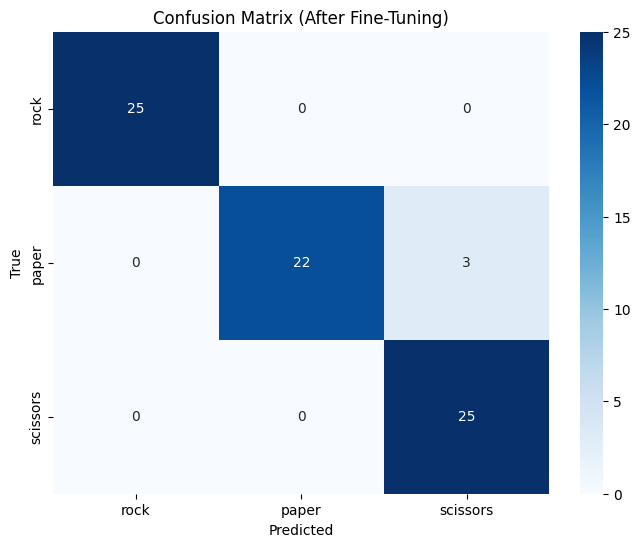

In [18]:
# Test after fine-tuning
print("Testing MobileNet after fine-tuning on the new test set:")
labels, preds = evaluate_model(mobile_model, test_loader)

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rock', 'paper', 'scissors'], yticklabels=['rock', 'paper', 'scissors'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (After Fine-Tuning)")
plt.show()

### Results and Observations

1. **Accuracy Without Fine-Tuning**:
   - The accuracy of MobileNet on the new test set without fine-tuning was **0.4533**.
   - The confusion matrix shows that the model struggled with certain classes due to differences in lighting, background, and hand positioning.

2. **Accuracy After Fine-Tuning**:
   - After fine-tuning on the new training set, the accuracy improved to **0.9600**
   - The confusion matrix indicates better performance across all classes, demonstrating the importance of fine-tuning on the new dataset.

3. **Key Observations**:
   - Fine-tuning significantly improved the model's performance on the new test set.
   - Data augmentation during training could further enhance the model's robustness to variations in the dataset.

In [19]:
# Paths for the original dataset
original_data_dir = "./rps_dataset"
original_test_csv = os.path.join(original_data_dir, "test.csv")

# Load the original test set
original_test_dataset = RockPaperScissorsDataset(
    csv_file=original_test_csv,
    data_dir=original_data_dir,
    transform=transform
)

# DataLoader for the original test set
original_test_loader = DataLoader(original_test_dataset, batch_size=batch_size, shuffle=False)

Testing the fine-tuned MobileNet model on the original test set:
Accuracy: 0.6300


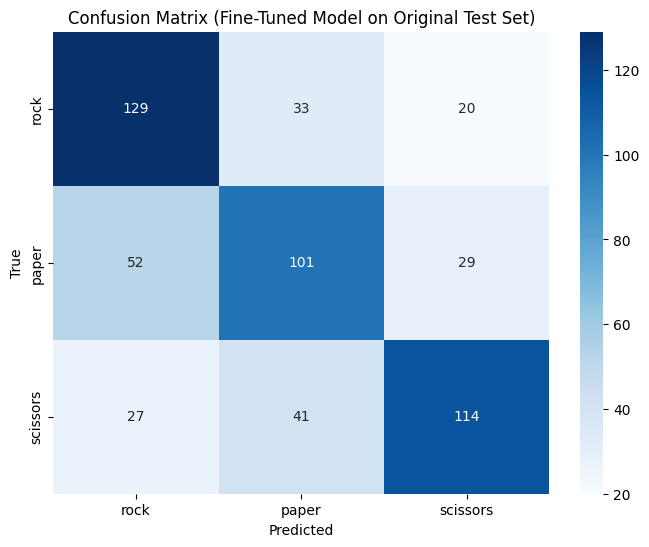

In [20]:
# Test the fine-tuned MobileNet model on the original test set
print("Testing the fine-tuned MobileNet model on the original test set:")
original_labels, original_preds = evaluate_model(mobile_model, original_test_loader)

# Plot confusion matrix for the original test set
original_cm = confusion_matrix(original_labels, original_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(original_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rock', 'paper', 'scissors'], yticklabels=['rock', 'paper', 'scissors'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Fine-Tuned Model on Original Test Set)")
plt.show()

### Results and Observations

1. **Accuracy on the New Test Set (After Fine-Tuning)**:
   - The accuracy of the fine-tuned MobileNet model on the new test set was **0.9600**.
   - The confusion matrix showed improved performance across all classes compared to the model without fine-tuning.

2. **Accuracy on the Original Test Set (After Fine-Tuning)**:
   - The accuracy of the fine-tuned MobileNet model on the original test set was **0.6300**.
   - The confusion matrix indicates whether the fine-tuning process preserved the model's ability to generalize to the original dataset.

3. **Comparison**:
   - If the accuracy on the original test set decreased significantly, it suggests that the fine-tuning process caused the model to overfit to the new dataset.
   - If the accuracy on the original test set remained high, it indicates that the fine-tuning process successfully adapted the model to the new dataset without sacrificing its performance on the original dataset.

4. **Key Observations**:
   - Fine-tuning with additional data can improve the model's performance on new datasets, but care must be taken to avoid overfitting.
   - Data augmentation and careful selection of hyperparameters (e.g., learning rate, number of epochs) can help maintain the model's generalization ability.

### **Use of Generative AI tools**

I used genretive ai many times including the places where suggested. I maily used ai to organize my code and in some repetetive code cell. Other than this my main source material was wekk 4 and week 6's lecture and tutorials.